# NPR News Sentiment Analysis:
## Getting to business giving NPR the business

by:

 - Joann Balraj
 - Brian Clements
 - David Rodriguez
 - Joshua Wheeler
 
--- 

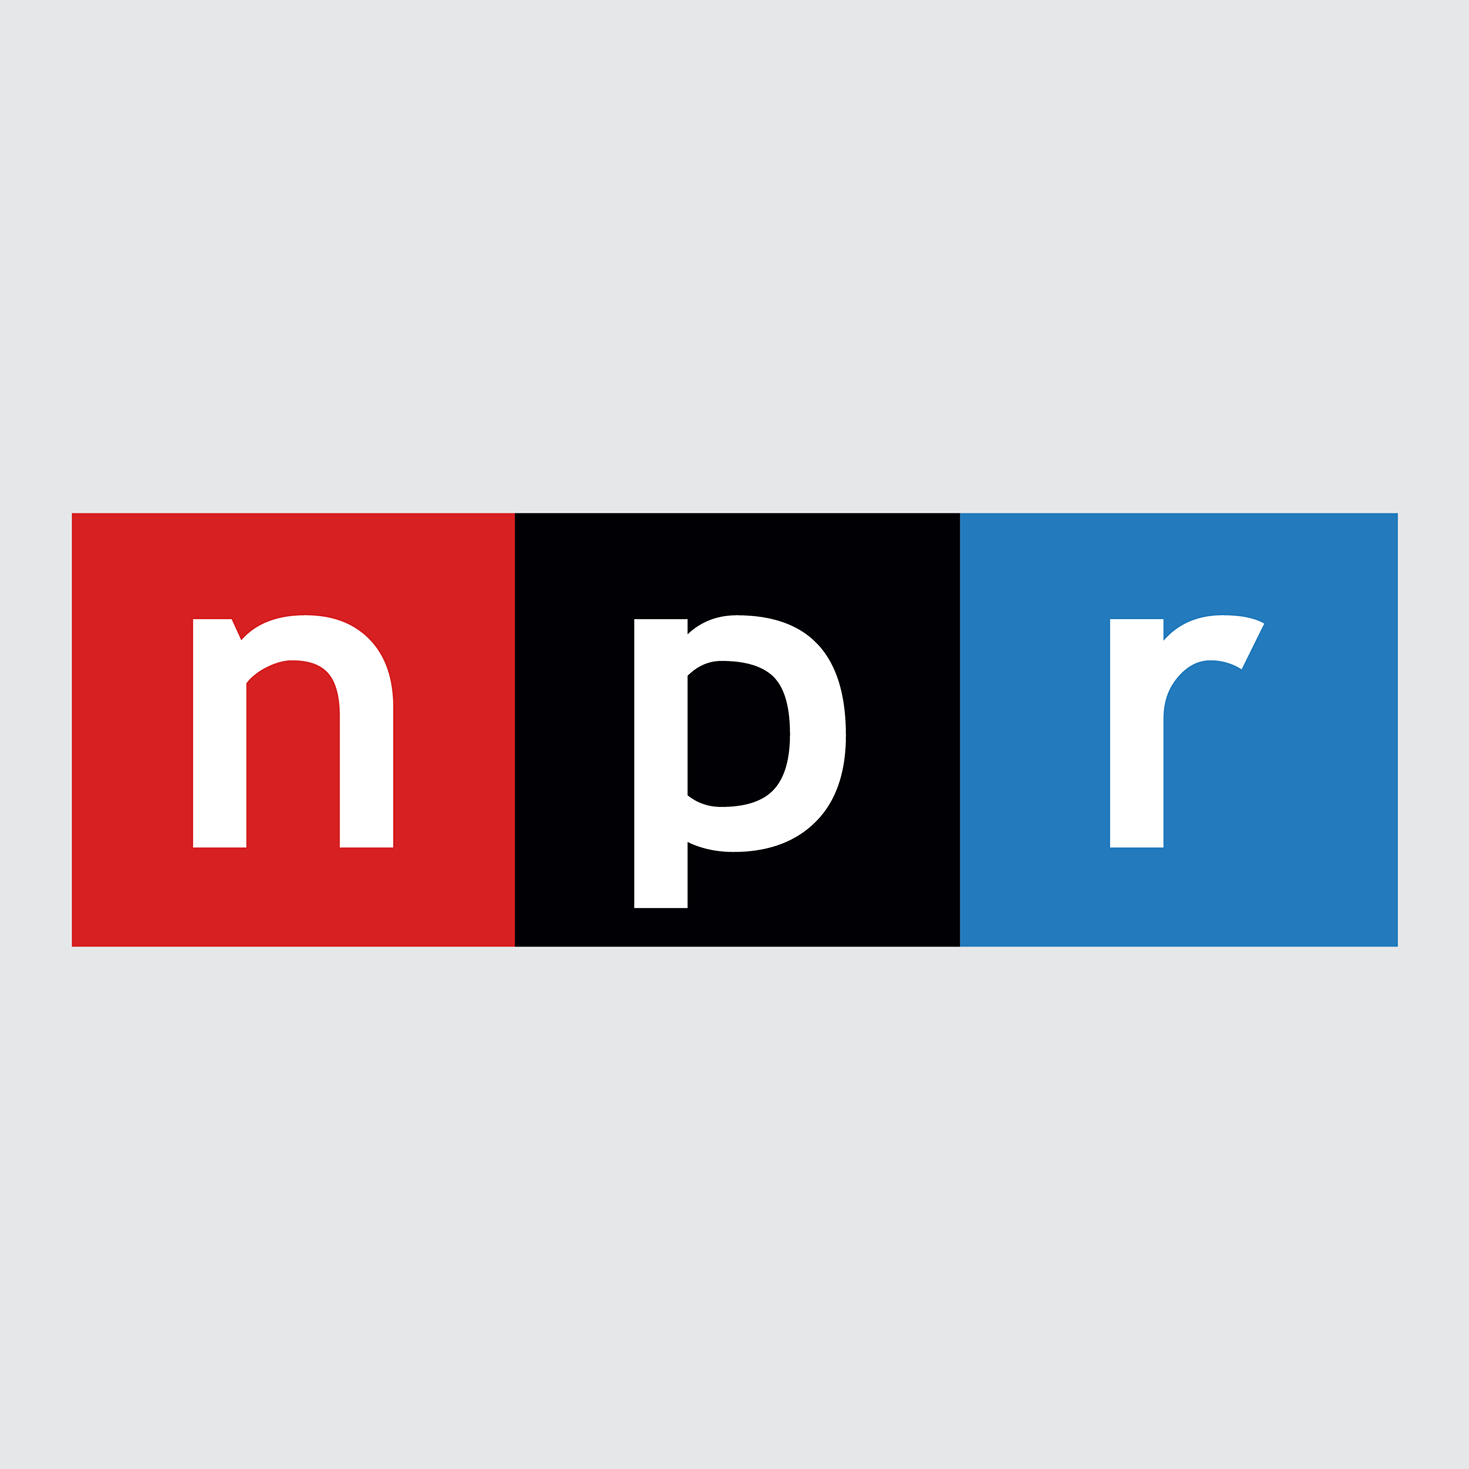

---

### Executive Summary

**Overview:**

 - Our aim is to do a study of `15 years of NPR news transcripts` to get an idea of the overall sentiment of NPR news over the years. We also expect some other interesting exploration, including predictions on whether the speaker is an NPR host or not, and potentially, what news category a story belongs to. Future iterations may include other exploration and modeling, including adding outside news sources and predicting fake vs. legitimate news.
 
**Goals:**

 - The ultimate goal of this project is to `build a model that predicts whether an utterance was said by a host or by a guest`. 
 - Additional goals include studying sentiment over time (including attempting to predict sentiment) and an exploration of the utterances, hosts and stories that were broadcast on NPR over the years in question.
 
**Conclusion/Takeaways:**

 - We were able to get great answers from the data in our exploration--demonstrating, for example, the `keen adherence to neutrality shown by NPR hosts in their utterances`. 
 - Other exploration did not evolve into clear takeaways, except to say it was not predictive. This is in reference to the analysis of sentiment over time, which, although some anecdotal trends seem to exist, on the whole is generally very full of noise and difficult to draw conclusions from.
 - The models we built were interesting and yielded worthwhile results--when predicting whether an utterance was said by a guest or host, our best model beat the baseline by over 23%. This seems a good start for, at a minimum, filtering out probable fake utterances.
 
**Recommendations**

 - We recommend our model be used as an `analytical tool of news articles`. 
 - NPR, for instance, may find this exploration useful for analytical reasons (do we need to address imbalances in tone between programs? hosts? over time?), but another stakeholder is the public writ large, which has an interest in understanding the content being broadcast by the largest not-for-profit news source on the radio waves. The classification power of our final model is also whether a quote actually belongs to an NPR correspondent.

---

## Project Description

 This Jupyter Notebook and presentation explore the NPR interview corpus. The data used relates to NPR radio interviews from 1999 to 2019. An important aspect of NPR as an independent media outlet is to effectively convey information to create a more informed public; we intend to build a machine learning model that interpets a corpus of interviews to predict sentiment scores.

 Accuracy (for classification) will be used as the primary metric for evaluation; many models will be built using different features and hyperparameters to find the model of best fit. One of the final deliverables will be the RMSE value resulting from the best model, comparable with the baseline accuracy.

 Additionally, a Jupyter Notebook with our findings and conclusions will be a key deliverable; many .py files will exist as support for the main Notebook (think "under-the-hood" coding that will facilitate the presentation).
 
---

In [1]:
import os
import unicodedata
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from time import strftime
from scipy.stats import f_oneway

import wrangle
import acquire
import prepare 
import explore
import cluster
import model

import re
import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

from scipy import stats
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

---

## Acquisition

Our data was acquired from kaggle.com by dowloading it directly from the [Interview: NPR Media Dialog Transcripts kaggle dataset](https://www.kaggle.com/shuyangli94/interview-npr-media-dialog-transcripts/code) website.

- After downloading the relevant .csv files, our working dataset comes from two different sources (`utterances.csv` and `episodes.csv`) combined into one. 
- Our acquire script also did the following:
 - Combined dataset was put together via inner join.
 - Unnecessary and/or redundant columns were dropped or renamed.  
 - The string columns were all converted to lowercase.
 - Finally, an additional column, is_host, was created to identify whether the speaker for a specific row was an NPR host or not.

---
## Preparation

The merged dataset from Kaggle went through the following preparation steps:

1. Looked up the top 10 hosts with the most speaking lines.
2. Using a mask with the episode ID from the top 10 hosts with the most speaking lines, a new dataframe was created from the result.
3. Any rows with foreign languages spoken were removed.
4. Any rows with no speaker listed were removed.
5. Duplicate and null values were dropped.
6. `Cleaned` and `lemmatized` column versions were created from the `utterances` column.
7. A column representing the sentiment score for each utterance was added.
8. Any date-like data was transformed into a datetime object.
9. Episodes prior to 2005 were dropped due to low observation count.
10. Renamed a couple columns for purposes of making working with this dataset easier.
11. The `episode_date` column was dropped.
12. The `speaker` column was modified via regular expression to extract the name of the speaker only.
13. Double checked our `is_host` column.


In [2]:
# prepare dataset from script functions
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [3]:
# dataset ready
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889851 entries, 0 to 3199856
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   story_id_num     int64  
 1   utterance_order  int64  
 2   speaker          object 
 3   utterance        object 
 4   program          object 
 5   title            object 
 6   is_host          bool   
 7   clean            object 
 8   lemmatized       object 
 9   vader            float64
 10  date             object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 160.4+ MB


---
## Exploration

Initial Questions:

- **Which NPR speakers have spoken the most lines spoken?**
    - `Neal Conan` has the most lines spoken in this dataset.
    - `Ira Flatlow` and `Steve Inskeep` come in at second and third place, respectively.

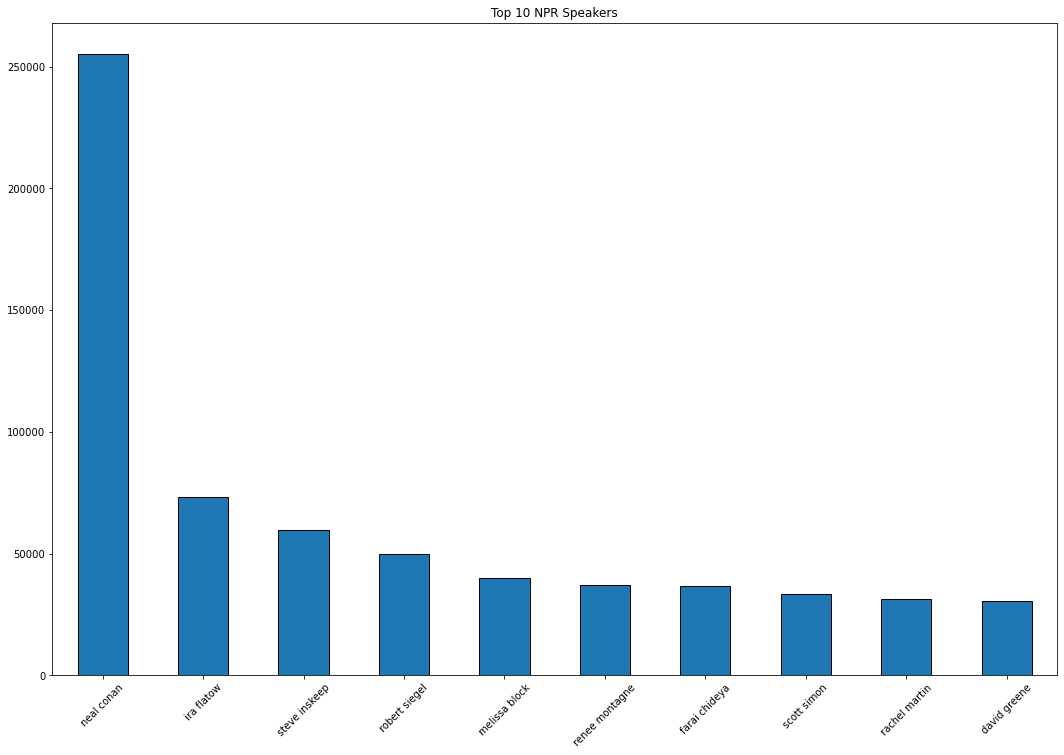

In [5]:
explore.top_npr_speakers(df)

- **Who asks the most questions?**
    - As shown below, Neal Conan has asked overr 250,000 questions on air! That's over 3 times the number two host in questions.
    - Conan hosted talk of the nation, a two-hour daily interview program for years.
    - Flatow hosted and still hosts Science Friday, a weekly interview program that started as a spinoff of Talk of the Nation

In [6]:
# create a question mark count column
df['question_mark_count'] = df.utterance.str.count(r"[\?]")

# extract the total number of question marks for every given speaker, display top ten
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,speaker,count
81830,neal conan,255146
29199,ira flatow,73209
98098,steve inskeep,59565
91806,robert siegel,49750
46070,melissa block,39983
89616,renee montagne,37241
23679,farai chideya,36719
94514,scott simon,33394
88612,rachel martin,31292
15210,david greene,30419


- **Do NPR hosts ask more questions than guests?**
    - Yes, our visual below provides ample proof that hosts ask far more questions than guests.

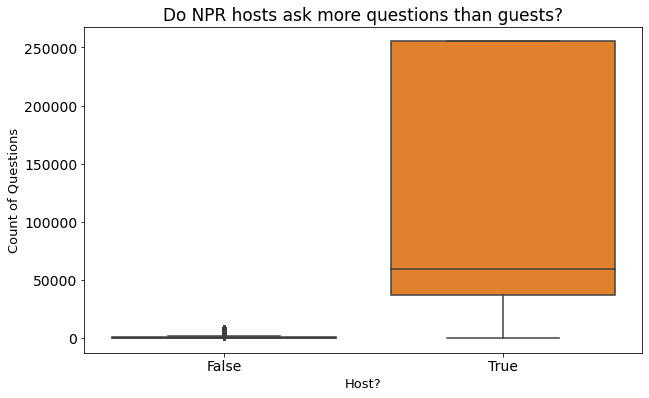

In [7]:
explore.npr_host_vs_guest(df)

- **Is there a difference in the mean sentiment by speaker? Program?**
    - As seen in the visualization below, the average sentiment score is relatively neutral accross all top hosts, although some rate higher:
        - Scott Simon, for instance, who hosts a weekend program
        - Rachel Martin bucks the trends: she co-hosts Morning Edition, a weekday daily with a lower average sentiment score overall
        - Stoic Melissa Block has the lowestvader score, and hosted All Things Considered for years, a daily afternoon news/politics program
    - The mean sentiment value is awfully close for everyone here, so we stats test it with an ANOVA test next...

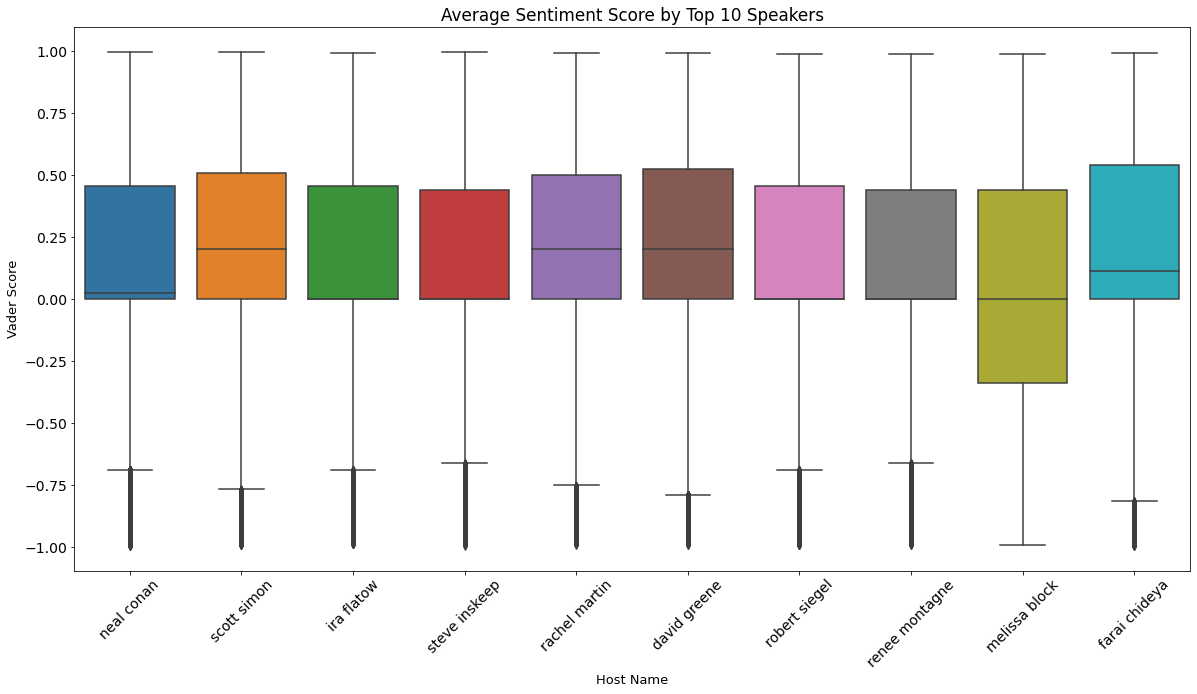

In [8]:
explore.avg_sentiment_top_speakers(df)

In [9]:
# create a null and alt hypothesis for stats testing
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"

alpha = 0.01 # let's be 99% certain the result we see isn't due to chance/randomness

**Set Hypothesis**

$H_{0}$: Average sentiment score is the same across hosts
 
$H_{a}$: Average sentiment score is different in at least one host of the group

In [10]:
# let's isolate the hosts for stats testing
neal_df = df[df.speaker == 'neal conan'].vader
ira_df = df[df.speaker == 'ira flatow'].vader
robert_df = df[df.speaker == 'robert siegel'].vader
steve_df = df[df.speaker == 'steve inskeep'].vader
melissa_df = df[df.speaker == 'melissa block'].vader
farai_df = df[df.speaker == 'farai chideya'].vader
renee_df = df[df.speaker == 'renee montagne'].vader
scott_df = df[df.speaker == 'scott simon'].vader
david_df = df[df.speaker == 'david greene'].vader
rachel_df = df[df.speaker == 'rachel martin'].vader

In [11]:
f, p = f_oneway(neal_df, ira_df, robert_df, steve_df, melissa_df, farai_df, renee_df, scott_df, david_df, rachel_df)
f, p

(614.2906018057929, 0.0)

In [12]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


- **What's the difference in sentiment score between hosts and non-hosts?**
    - NPR hosts tend to keep it neutral in the sentiment department.
    - The average sentiment score for non-hosts is somewhat higher than for the hosts.

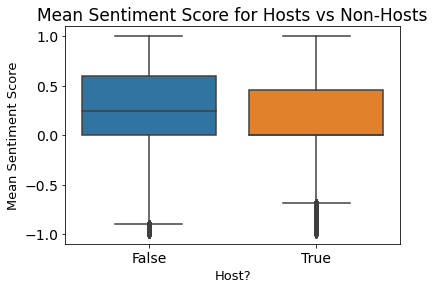

In [13]:
explore.sentiment_host_nonhost(df)

In [14]:
# create a null and alt hypothesis for stats testing
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"

alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

**Set Hypothesis**

$H_{0}$: Hosts and Non-hosts have the same sentiment score
 

$H_{a}$: Hosts and Non-hosts have different sentiment scores

In [15]:
# host df
host_df = df[df.is_host == True]

# create a non-host df
non_host_df = df[df.is_host == False]

#stats testing on the same
t, p = stats.ttest_ind(host_df.vader,non_host_df.vader)
t, p

(-46.94726312379546, 0.0)

In [16]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


- **How about sentiment score by year? Month? Day?**
    - There weren't enough data points fro 2000 through 2003 so those values were dropped.
    - Visualization by year did not demonstrate a trend.
    - Visualization by month also didn't demonstrate a trend.
    - However, the impression is that sentiment is a little higher on the weekend, dipping Mondays and rising Fridays into the weekend.

In [17]:
# set date to datetime
date_df = df.copy()

date_df['date'] = pd.to_datetime(date_df.date)

# set date to index
date_df = date_df.set_index('date').sort_index()

# resample vader score by year
date_df.resample('Y').vader.mean().to_frame()

,vader
date,
2005-12-31,0.169318
2006-12-31,0.161386
2007-12-31,0.180956
2008-12-31,0.209604
2009-12-31,0.193803
2010-12-31,0.184555
2011-12-31,0.172065
2012-12-31,0.188927
2013-12-31,0.157618


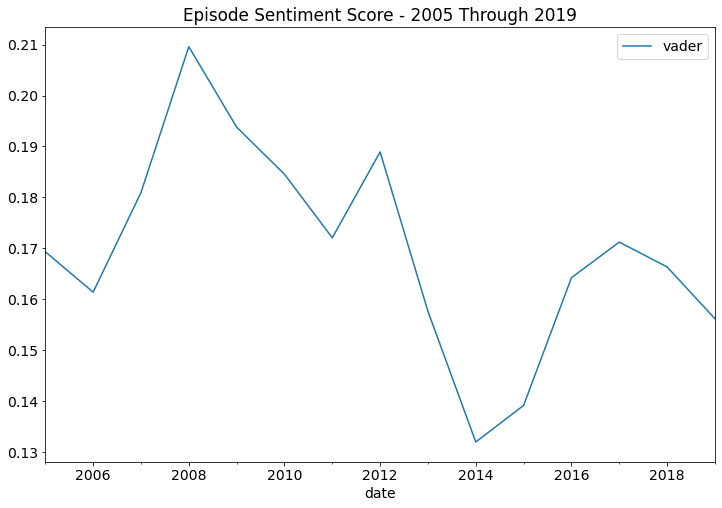

In [18]:
explore.episode_sentiment_year(df)

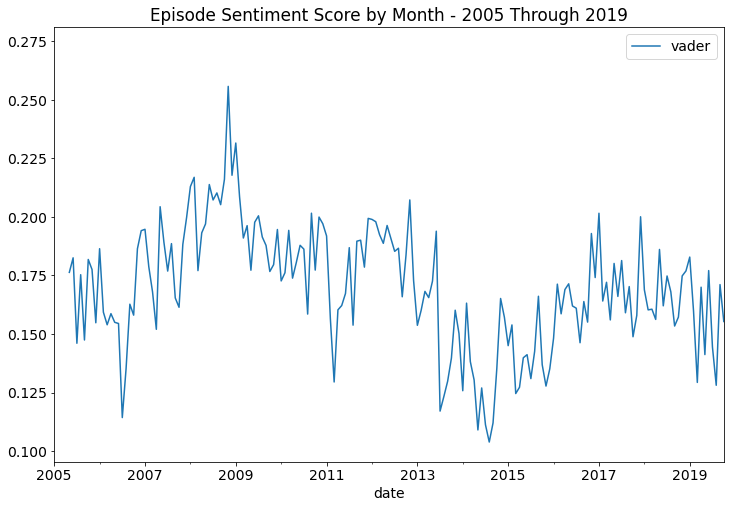

In [19]:
explore.episode_sentiment_month(df)

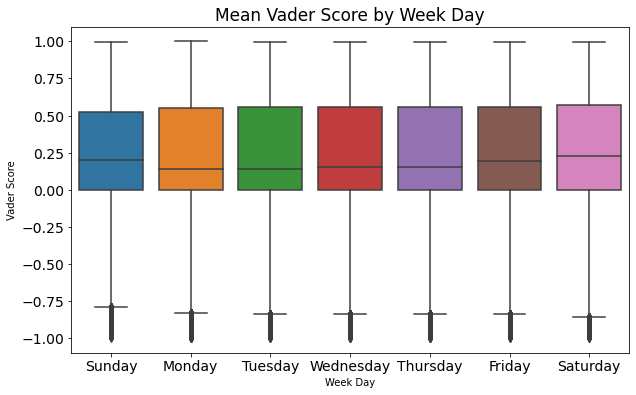

In [20]:
explore.episode_sentiment_weekday(df)

- **How Does Sentiment Score Differ by Program?**
    - Note the programs that have gone off air:
        - Talk of the Nation
        - Day to Day
        - News & Notes
    - Also, there is some difference in sentiment from program to program.
    - Weekend Edition (Sat and Sun) have higher sentiment scores - these programs try to be a little on the lighter side for the weekend.
    - We're definitely starting off the day on the most pessimistic note:
        - (And ending it too... All Things Considered is the afternooon daily news/politics program)

In [21]:
# what are the different programs?
df.program.value_counts().index.to_list()

['talk of the nation',
 'morning edition',
 'all things considered',
 'weekend edition saturday',
 'news & notes',
 'weekend edition sunday',
 'day to day']

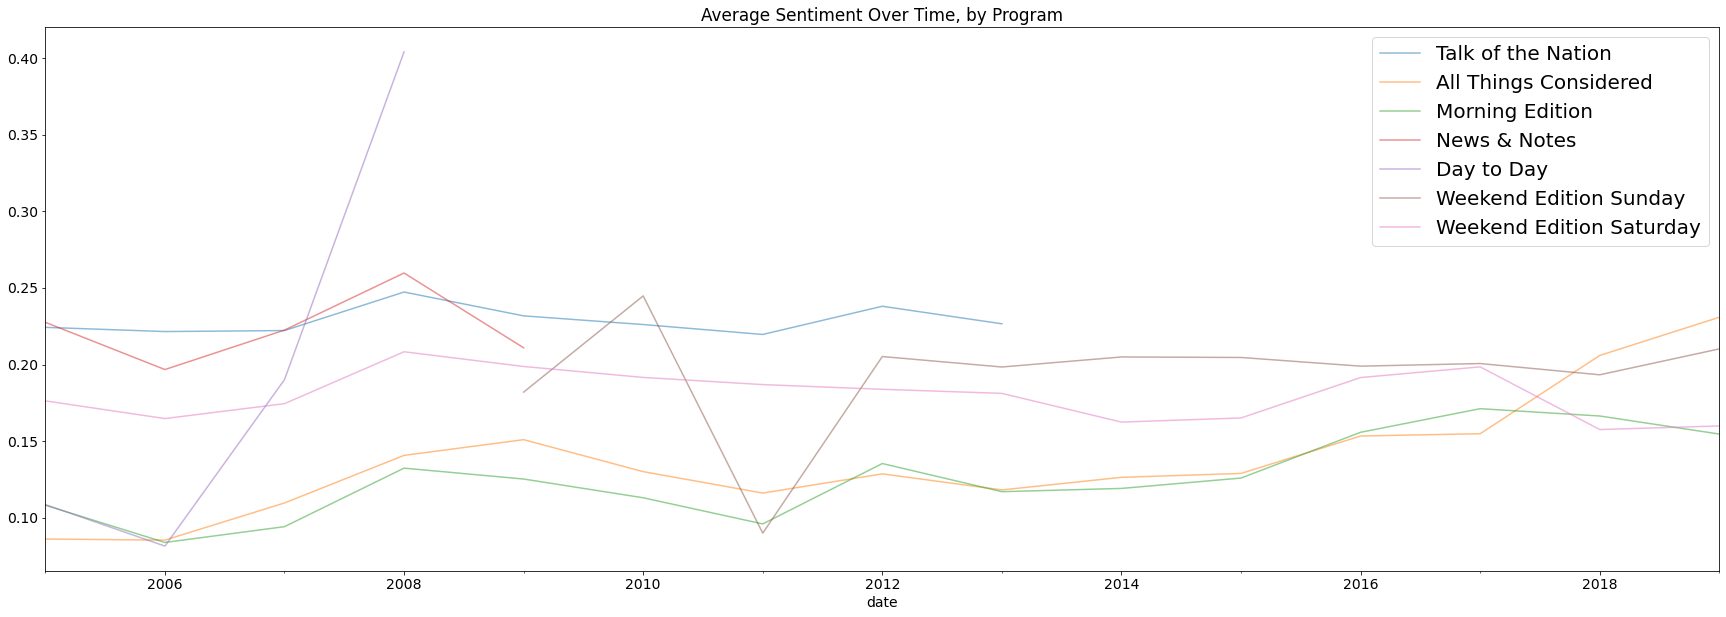

In [22]:
explore.program_sentiment(df)

In [23]:
# Define hyptoheses
null_hypothesis = "The different programs have the same sentiment score"
alternative_hypothesis = "At least one program has a different sentiment score"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

**Set Hypothesis**

$H_{0}$: The different programs have the same sentiment score
 
$H_{a}$: At least one program has a different sentiment score

In [24]:
#  making df for each program
talk_of_the_nation_df = df[df.program == 'talk of the nation']
morning_edition_df = df[df.program == 'morning edition']
all_things_considered_df = df[df.program == 'all things considered']
news_and_notes_df = df[df.program == 'news & notes']
weekend_edition_saturday_df = df[df.program == 'weekend edition saturday']
weekend_edition_sunday_df = df[df.program == 'weekend edition sunday']
day_to_day_df = df[df.program == 'day to day']

# statistical test
f, p = f_oneway(talk_of_the_nation_df.vader, all_things_considered_df.vader,
                morning_edition_df.vader, news_and_notes_df.vader, day_to_day_df.vader, 
                weekend_edition_sunday_df.vader, weekend_edition_saturday_df.vader,)
f, p

(3449.095778762551, 0.0)

In [25]:
# Return stats results
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that The different programs have the same sentiment score
We move forward with the alternative hypothesis that At least one program has a different sentiment score


- **What are the most frequently used words by hosts?**
    - The most common words are: `'talk'`, `'let'`, `'nation'`, `'today'`, and `'new'`.

In [26]:
# top 10 hosts with the most obseravtions
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

# aggregate utterances by the speakers that are in top 10 hosts
df.dropna(inplace = True)

host_words = df[df.speaker.isin(hosts_with_the_most)].groupby('speaker')['clean'].agg(lambda col: ' '.join(col))

In [27]:
# adding in additional stopwords

more_stopwords = pd.read_excel('stop_words_df.xlsx')
more_stopwords = more_stopwords.words.to_list()

host_words = host_words.apply(prepare.string_cleaning).apply(prepare.remove_stopwords, extra_words = more_stopwords)

In [28]:
# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan'].split()).value_counts()

In [29]:
# create word counts dataframe of all host word frequencies
word_counts = pd.concat([conan_freq, flatow_freq, inskeep_freq, siegel_freq, block_freq, montagne_freq, chideya_freq, simon_freq, martin_freq, greene_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['conan', 'flatow', 'inskeep', 'siegel', 'block', 'montagne', 'chideya', 'simon', 'martin', 'greene']
word_counts.head(5)

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
?,68537,32383,16988,15371,11995,7618,19026,12557,13374,9501
talk,32929,6854,1687,1024,1382,823,1799,736,970,1005
let,24769,5930,2808,1092,1082,1010,2823,1196,1353,1764
nation,24250,1491,478,360,255,367,322,271,119,242
today,19081,2382,2695,4307,3209,2077,1591,929,1195,1385


In [30]:
# create dictionary for word clouds
word_lists = {'conan': host_words['neal conan'], 
'flatow': host_words['ira flatow'], 
'inskeep': host_words['steve inskeep'], 
'siegel': host_words['robert siegel'], 
'block': host_words['melissa block'], 
'montagne': host_words['renee montagne'], 
'chideya': host_words['farai chideya'], 
'simon': host_words['scott simon'], 
'martin': host_words['rachel martin'], 
'greene': host_words['david greene']}

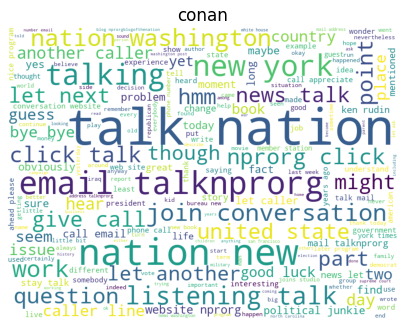

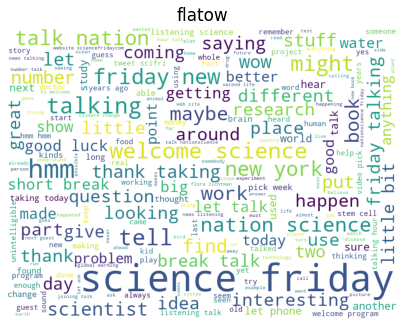

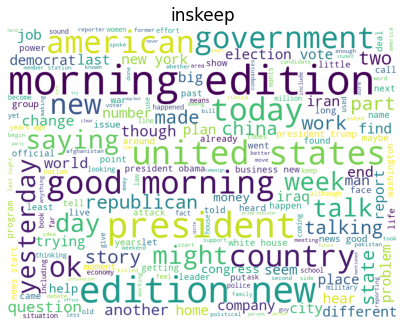

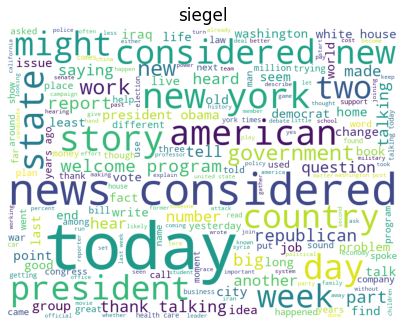

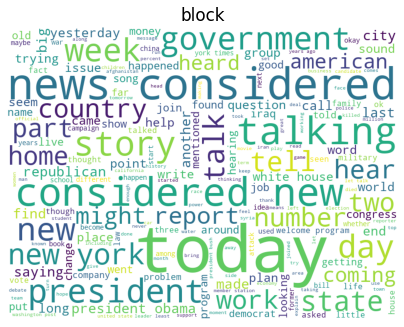

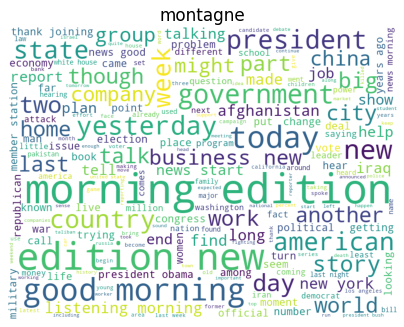

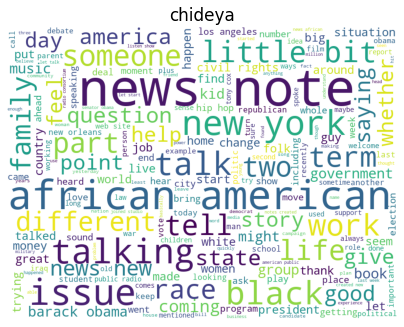

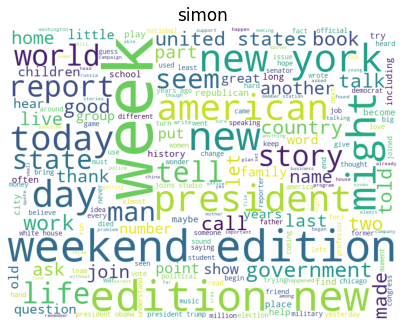

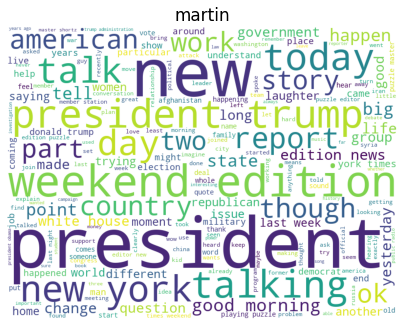

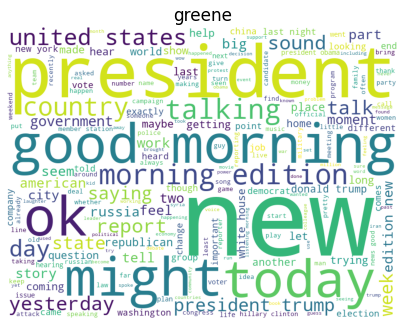

In [31]:
# word clouds
for h in word_lists:
    plt.figure(figsize = (7,7))
    img = WordCloud(background_color = 'white', width = 800, height = 600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

- **How Does Word Count and Host status interact with Vader Sentiment Score?**
     - There is statistical evidence that the statement: means between clusters are equal is not true.
     - There is statistical evidence that the statement: no correlation between clusters and being a host is not true.

In [32]:
# create continuous variables easily available to us
df['message_length'] = df.clean.apply(len)
df['word_count'] = df.clean.apply(str.split).apply(len)
df['question_mark_count'] = df.utterance.str.count(r"[\?]")

- ### Are clusters helpful?
    - Create clusters based on continuous features
    - Any noticeable distinctions between them?
    - Do they correlate with being a host?
    - Do they affect the model?

In [33]:
train, validate, test, train_scaled, validate_scaled, test_scaled, X_train_cluster = cluster.get_clusters(df)

Text(0.5, 0.92, 'NPR Clusters by Sentiment, Word Count, and Question Marks')

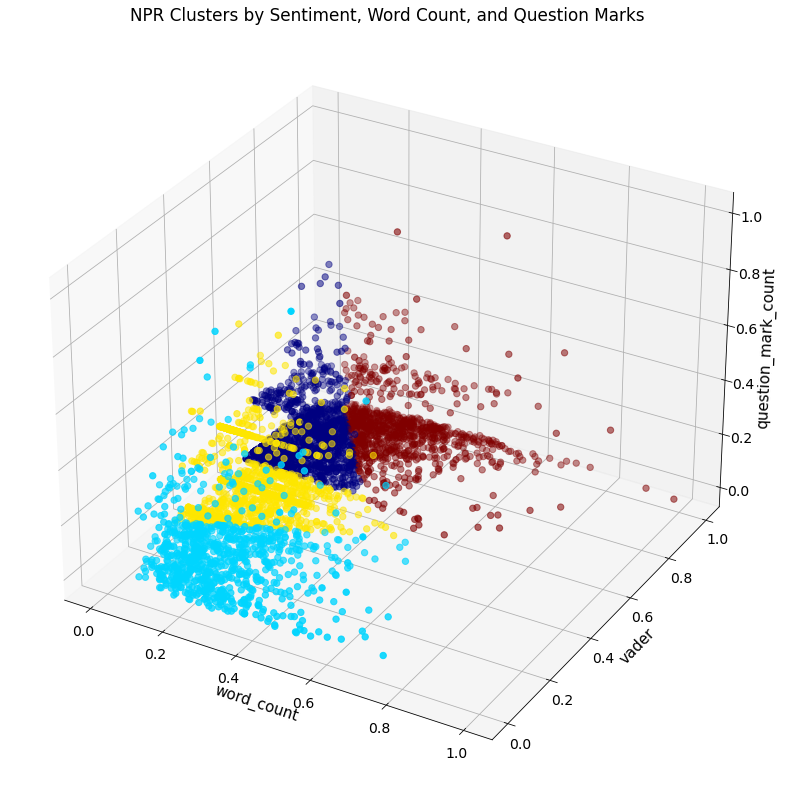

In [34]:
# 3D Clusters
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, projection = '3d')
x = X_train_cluster.word_count
y = X_train_cluster.vader
z = X_train_cluster.question_mark_count
ax.scatter(x,y,z, c=X_train_cluster.cluster, s = 40, cmap = 'jet')
# ax.legend()
ax.set_xlabel('word_count', fontsize = 15)
ax.set_ylabel('vader',fontsize = 15)
ax.set_zlabel('question_mark_count',fontsize = 15)
plt.title('NPR Clusters by Sentiment, Word Count, and Question Marks')

In [35]:
f, p = stats.f_oneway(train_scaled[train_scaled.cluster == 0].cluster,
                     train_scaled[train_scaled.cluster == 1].cluster,
                     train_scaled[train_scaled.cluster == 2].cluster,
                     train_scaled[train_scaled.cluster == 3].cluster)

**Set Hypothesis**

$H_{0}$: Means between clusters are equal
 
$H_{a}$: Means between clusters are not equal

In [36]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


**Set Hypothesis**

$H_{0}$: No correlation between clusters and being a host
 
$H_{a}$: Correlation between clusters and being a host

In [37]:
x = train_scaled.cluster
y = train_scaled.is_host

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


---
### Topic Modeling
 
 - We explore the different `STORIES` in the dataset in this section. 
 - We build topics from Latent Dirichlet Allocation methods

In [38]:
# Define our stories--aggregating on story_id_num and extracting
# host and program names from main dataframe
# vader was run on the stories
# the resulting df was saved as a csv for easy access
stories = pd.read_csv('stories.csv').drop(columns = ['Unnamed: 0'])
stories.head()

,story_id_num,lemmatized,vader,title,date,host,program
0,17,he is in cahoot with a foreign government to m...,0.9964,n.j. democrat on reported whistleblower compla...,2019-09-22,melissa block,weekend edition sunday
1,18,"come with concrete plan , not beautiful speech...",0.9993,"ahead of climate summit, 2 views from cities i...",2019-09-22,melissa block,weekend edition sunday
2,19,if you stand outside the old dekalb county cou...,0.9974,"barred from removing confederate monument, cou...",2019-09-22,melissa block,weekend edition sunday
3,20,you may have spotted pink salt in your superma...,0.4950,pakistan's pink himalayan salt has become a ma...,2019-09-22,melissa block,weekend edition sunday
4,21,"singing in foreign language . the other day , ...",0.9730,"10 years after haiti's earthquake, 'this music...",2019-09-22,melissa block,weekend edition sunday


In [39]:
# define a df of the stories with the higheest possible sentiment 
brightest_stories = stories[stories.vader == 1]
brightest_stories.shape

(1345, 7)

In [40]:
# get a sample of some of the brightest story titles
brightest_stories.title.sample(10).to_list()

['the road to building greener cars',
 'the changing face of war in afghanistan',
 'how well does hollywood portray your job?',
 "searching for 'the particle at the end of the universe'",
 "gi bill doesn't cover costs, critics say",
 'democrat pulls off election day upset in new york',
 "a valentine's mix tape from 'talk of the nation'",
 "students find it's tough to graduate in four years",
 "the day buddy guy 'left home,' bound for the blues",
 'will work for free? the future of the unpaid internship']

In [41]:
# The same, but for the "darkest" stories
darkest_stories = stories[stories.vader == -1]

In [42]:
for story in darkest_stories.title:
    print(story)

the epidemiology of gun violence: race, region and policy
how do you define a hate crime?
understanding suicide terrorism and how to stop it
deconstructing 'myths about suicide'
the legacy of bush's 'war on terror'
who carries out suicide bombings?
how do we define terrorism?
should the guantanamo prison be closed?
'war of nerves': a history of chemical weapons


- There are only 9 stories with the lowest sentiment score, and over 1300 with the most positive

### Below, we build an unsupervised ML model to get topics from the TITLES of the stories

In [43]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = stories.title.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['democrat', 'reported', 'whistleblower', 'complaint', 'trump']


In [44]:
# # Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [45]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # see https://spacy.io/models/en for info on this pipeline
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

In [1]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

NameError: name 'data_lemmatized' is not defined

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
# use the above-selected parameters to train the model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

ModuleNotFoundError: No module named 'pyLDAvis'

### The lambda bar at the top right lets you see the words' frequencies in relation to the whole corpus versus their particular topic.

## Takeaway: the topics are somewhat comprehensible, but there is plenty of ambiguity.

---
### Modeling
 
 - **`Evaluation`**:
     - We have decided to go with accuracy as our evaluation metric as it is best suited for our use-case

In [ ]:
eval_df, train, validate, test = model.run_modeling()

The df has 1889857 rows and 12 columns.
train shape is (56000, 13)
validate shape is (24000, 13)
test shape is (20000, 13)
Basic Splits Created
TF_IDF Splits Created
Count Vectorizer Splits Created
Logistic Regression Beginning
LR done
Decision Tree beginning
DT done
Random Forest beginning
RF done


#### Note:
 - We've sampled down the original df and derived all the splits based on 'rest', which was based on the small_df sample.

In [ ]:
eval_df

,Model_Type,Train_Accuracy,Validate_Accuracy,Accuracy_Difference,Beats_Baseline_By
0,baseline_pred,0.621768,0.621792,-0.000024,-0.002851
0,Log_Reg_Just_Features,0.673982,0.676625,-0.002643,0.051982
0,Log_Reg_Just_TFIDF,0.816875,0.774917,0.041958,0.150274
0,Log_Reg_TFIDF_Plus_Features,0.756839,0.757292,-0.000452,0.132649
0,Log_Reg_CV,0.849893,0.756042,0.093851,0.131399
0,Log_Reg_CV_Plus_Features,0.774875,0.768167,0.006708,0.143524
0,Decision_Tree_Just_Features,0.725000,0.721375,0.003625,0.096732
0,DecisionTree_Just_TFIDF,0.688089,0.686833,0.001256,0.062190
0,Decision_Tree_TFIDF_PlusFeatures,0.738089,0.739292,-0.001202,0.114649
0,DecisionTree_Just_Countvectorizer,0.688125,0.686667,0.001458,0.062024


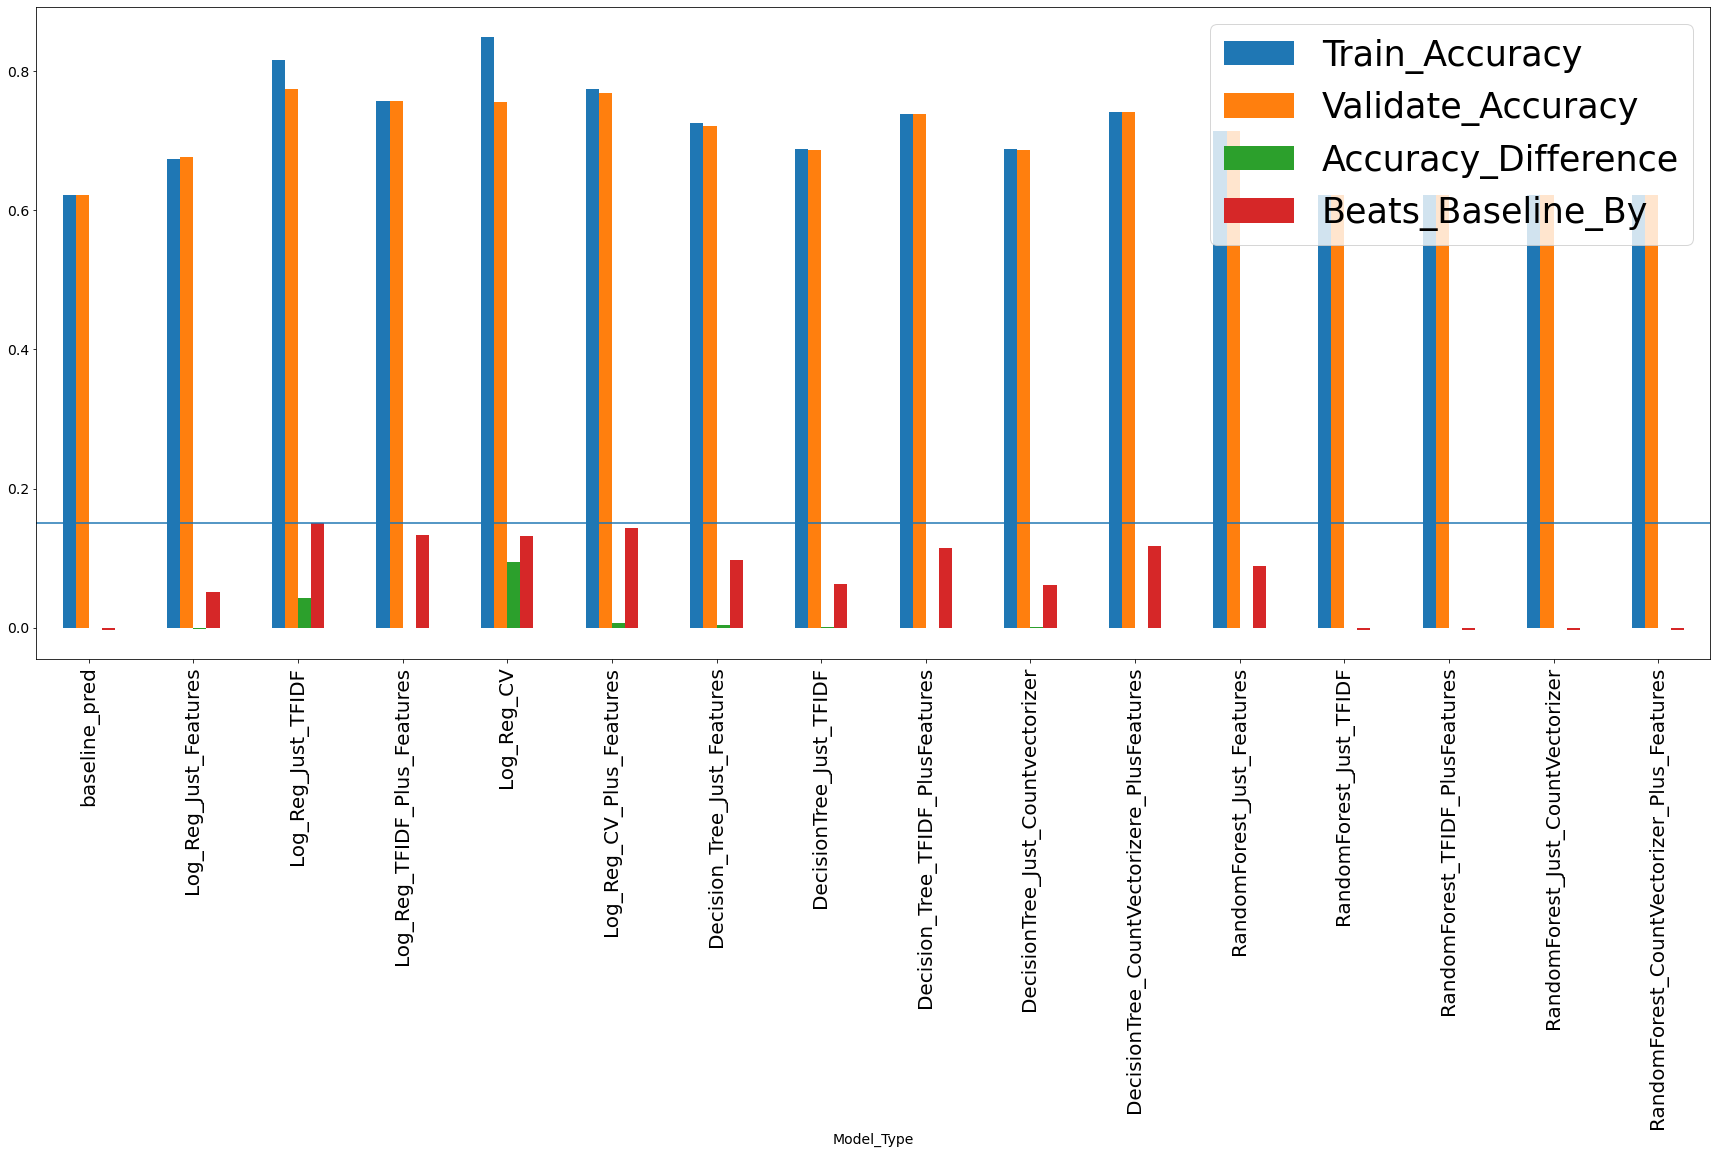

In [ ]:
from matplotlib import cm
# define columns of eval df for use plotting below
columns = ['Train_Accuracy', 'Validate_Accuracy','Accuracy_Difference', 'Beats_Baseline_By']
# cmap = cm.get_cmap('viridis')
# plot all the results, grouped by model
eval_df.plot(x='Model_Type', y=columns, kind="bar", figsize=(30,12))#,cmap=cmap)

plt.legend(prop={'size': 35}, loc='upper right')#(loc=(1.01,1.2), bbox_to_anchor=(.5, 0., .5, .5))
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)

# add h line for highest gross performing model
plt.axhline(y=eval_df.Beats_Baseline_By.max())
plt.xticks(rotation=90, fontsize=20);

 - **`Best Performing Model - Logistic Regresion, Count Vectorizer with Features`**

In [ ]:
cv = CountVectorizer()

In [ ]:
print('Train Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(train.actual, train.predicted_X_cv_plus_features)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_X_cv_plus_features)))
print('---')

print('Test Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(test.actual, test.predicted_X_cv_plus_features)))
print(classification_report(test.actual, test.predicted_X_cv_plus_features))

Train Accuracy, Countvectorizer_PlusFeatures: 77.49%
---
Validate Accuracy, Countvectorizer_PlusFeatures: 76.82%
---
Test Accuracy, Countvectorizer_PlusFeatures: 77.06%
              precision    recall  f1-score   support

       False       0.78      0.87      0.83     12436
        True       0.74      0.60      0.67      7564

    accuracy                           0.77     20000
   macro avg       0.76      0.74      0.75     20000
weighted avg       0.77      0.77      0.76     20000



 - Based on the prediction from test set from our best performing model, our prediction `improves over the baseline by 21 %.`
 --- 
## Delivery
 
### Key findings, recommendations and takeaways:
We were able to get great answers from the data in our `exploration`--demonstrating, for example, the `keen adherence to neutrality` shown by NPR hosts in their utterances. Other exploration did not evolve into clear takeaways, except to say it was not predictive. This is in reference to the `analysis of sentiment over time,` which, `although some anecdotal trends seem to exist,` on the whole is generally very full of noise and `difficult to draw conclusions from.`

The models we built were interesting and yielded worthwhile results--when predicting whether an utterance was said by a guest or host, our `best model beat the baseline by 21%.` This seems a good start for, at a minimum, filtering out probable fake utterances.

Additionally, please refer to these [companion presentation slides](https://www.canva.com/design/DAE4poq4II4/jsdatoqNDz15giVLWN2k_Q/view?utm_content=DAE4poq4II4&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink).

#### Recommendations:
`We recommend our model be used as an analytical tool of news articles.` NPR, for instance, may find this exploration useful for analytical reasons (do we need to address imbalances in tone between programs? hosts? over time?), but another stakeholer is the public writ large, which has an interest in understanding the content being broadcast by the largest not-for-profit news source on the radio waves.

#### Next Steps:

This datset provides ample opportunities for exploration, and any number could be suggested, such as:

- Network diagrams for the relationship between hosts and programs
- Radial tree for hosts and top words said
- Topic modeling
- Evaluating our Prophet model for the time series analysis (maybe we have a prediction of future sentiment after all?)
- Small issues that occured when lemmatizing
- Continued trimming by adding stopwords
- Expore the effect of the question mark count--is this an example of target leakage? Or just low-hanging fruit?
